In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from itertools import product
from dataclasses import dataclass
import os
import math
import sys
from typing import Dict, Any, List, Optional
sys.path.append('../../../../')

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter

from multitask_nlp.utils.plotting import Task, get_overall_score, visualize_boxplot, plot_gain_matrix

color_pallette = 'muted'
sns.set_theme(style='whitegrid', context='talk', palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

tasks = [
    Task(name='Aspectemo', measure='micro_f1_sentiment', 
         measure_name='Micro F1', size=1303),
    Task(name='KPWr_n82', measure='micro_f1_ner_tags', 
         measure_name='Micro F1', size=10125),
    Task(name='NKJP1M', measure='accuracy_pos', 
         measure_name='Accuracy', size=14787),
    Task(name='CCPL', measure='accuracy_pos', 
         measure_name='Accuracy', size=19481)
]

cols_to_display = ['dataset', 'learning_kind', 'model_name', 'model_type',
       'mt_dataset_type',  'scale_class_loss', 'uncertainty_loss', 'type', 'overall_score', 'weighted_overall_score']

In [2]:
for task in tasks:
    print(task.name, end='')
    if task.short_name is not None:
        print(f' ({task.short_name}), ', end='')
    else:
        print(', ', end='')

Aspectemo, KPWr_n82, NKJP1M, CCPL, 

In [3]:
def get_type(row):
    ttype = row['learning_kind']
    if not pd.isna(row['mt_dataset_type']):
        ttype += '_' + str(row['mt_dataset_type'])
        if row['mt_dataset_type'] == 'proportional_sampling':
            ttype += r'_$\alpha={}$'.format(row['alpha'])
        
    return ttype

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['uncertainty_loss'] = df['uncertainty_loss'].fillna(False)
    df['type'] = df.apply(lambda x: get_type(x), axis=1)
    df['overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks), axis=1)
    df['weighted_overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks, weighted=True), axis=1)
    
    for scale_class_loss, uncertainty_loss, model_name in product(
            df['scale_class_loss'].unique(), df['uncertainty_loss'].unique(), df['model_name'].unique()):
        curr_df = df[(df['learning_kind'] == 'STL') & 
                     (df['scale_class_loss'] == scale_class_loss) &
                     (df['uncertainty_loss'] == uncertainty_loss) &
                     (df['model_name'] == model_name)]

        if len(curr_df) > 0:   
            stl_results = {}
            for task_name in curr_df.dataset.unique():
                for task in tasks:
                    if task_name == task.name:
                        col_measure = f'{task.name}_test_{task.measure}'
                        stl_results[task.name] = curr_df[curr_df.dataset == task.name][col_measure].values, task.size

            total_size = sum([task.size for task in tasks])
        
            overall_results = sum([v[0] for v in stl_results.values()]) / len(tasks)
            weighted_overall_results = sum([v[1]*v[0] for v in stl_results.values()]) / total_size

            records = [
                {'learning_kind': 'STL',
                 'type': 'STL', 
                 'scale_class_loss': scale_class_loss, 
                 'uncertainty_loss': uncertainty_loss,
                 'model_name': model_name,
                 'overall_score': r1, 
                 'weighted_overall_score': r2}
                for r1, r2 in zip(overall_results, weighted_overall_results)
            ]
            df = pd.concat([df, pd.DataFrame(records)], ignore_index=True) 

    return df

In [4]:
def get_model_kind(r):
    kind = r['model_name']
    if r['scale_class_loss'] not in (None, 'none'):
        kind += ' ' + r['scale_class_loss']
    if r['uncertainty_loss'] is True:
        kind += ' UW'
        
    return kind

def format_score(x):
    if x == 0:
        return '00.00'
    else:
        return f'{round(100*x, 2):.2f}'


# Eksperyment 1

- Modyfikacje fun. straty: brak | skalowanie log
- Rodzaje MTL: round robin, sampling, proportional sampling $\alpha=0.2$, annealing sampling 
- Powtórzenia: 5
- Liczba Epok: 10
- Learning rate: 1e-4
- Max length: 256
- Batch size: 32

In [5]:
df = load_results_df('mtl_polish_seq_labelling_results.csv')
df['model_kind'] = df.apply(lambda r: get_model_kind(r), axis=1)

In [6]:
# df[['batch_size', 'learning_rate', 'max_length', 'model_name', 'model_type', 'mt_dataset_type', 
#     'num_epochs', 'scale_class_loss', 'warmup_proportion', 'weight_decay', 'alpha', 'steps']].drop_duplicates()

In [7]:
df.value_counts(["type", "model_kind", "scale_class_loss"])

type                                    model_kind          scale_class_loss
STL                                     polish-roberta      none                25
                                        polish-roberta log  log                 25
MTL_annealing_sampling                  polish-roberta      none                 5
                                        polish-roberta log  log                  5
MTL_proportional_sampling_$\alpha=0.2$  polish-roberta      none                 5
                                        polish-roberta log  log                  5
MTL_round_robin                         polish-roberta      none                 5
                                        polish-roberta log  log                  5
MTL_sampling                            polish-roberta      none                 5
                                        polish-roberta log  log                  5
dtype: int64

In [9]:
# with pd.option_context('display.max_rows', None):
#     display(df[cols_to_display + ['model_kind']])
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'scale_class_loss', 'epoch', 'num_epochs', 'trainer/global_step', 'Runtime']])
# df['model_kind'].unique()
# df['model_kind'].value_counts()

In [8]:
df['model_kind'].value_counts()

polish-roberta log    45
polish-roberta        45
Name: model_kind, dtype: int64

In [9]:
df['type'].unique()

array(['MTL_annealing_sampling',
       'MTL_proportional_sampling_$\\alpha=0.2$', 'MTL_sampling',
       'MTL_round_robin', 'STL'], dtype=object)

In [11]:
type_order = ['STL', 'MTL_round_robin', 'MTL_sampling', 
         'MTL_proportional_sampling_$\\alpha=0.2$', 'MTL_annealing_sampling']

scaling_type_order = ['none', 'log']
    
order = [(t, st) for t in type_order for st in scaling_type_order]
    
agg_dict = {task.short_name if task.short_name is not None else task.name:
            (f'{task.name}_test_{task.measure}', 'mean') for task in tasks}

agg_dict.update({
    'Overall': (f'overall_score', 'mean'),
    'Weighted Overall': (f'weighted_overall_score', 'mean') 
})

result_df = df.groupby(['type', 'scale_class_loss']).agg(**agg_dict)

for col in agg_dict.keys():
    result_df[col] = result_df[col].apply(lambda x: format_score(x))
    
result_df = result_df.T
result_df = result_df[type_order]

result_df = result_df.rename(columns={c: ' '.join(c.split('_')) for c in result_df.columns.levels[0]}, level=0)
result_df = result_df.rename(columns={c: c.capitalize() for c in result_df.columns.levels[1]}, level=1)

# result_df = result_df.T

In [13]:
result_df.to_csv(f'mtl_seq_lab_agg_results.csv', index=True)
result_df

type                STL        MTL round robin        MTL sampling         \
scale_class_loss    Log   None             Log   None          Log   None   
Aspectemo         57.01  57.01           17.27  17.27        23.49  34.63   
KPWr_n82          35.16  35.16           26.07  26.07        25.75  37.96   
NKJP1M            97.04  97.04           43.15  43.15        41.17  59.28   
CCPL              89.87  89.87           32.27  32.27        35.22  48.90   
Overall           69.77  69.77           29.69  29.69        31.41  45.19   
Weighted Overall  79.13  79.13           33.99  33.99        34.71  49.43   

type             MTL proportional sampling $\alpha=0.2$         \
scale_class_loss                                    Log   None   
Aspectemo                                         57.90  46.87   
KPWr_n82                                          64.54  56.01   
NKJP1M                                            96.75  95.84   
CCPL                                              74.84  75.35   
Overall                                           73.51  68.52   
Weighted Overall                                  79.16  76.88   

type             MTL annealing sampling         
scale_class_loss                    Log   None  
Aspectemo                         57.06  52.98  
KPWr_n82                          65.35  63.21  
NKJP1M                            96.73  96.82  
CCPL                              74.76  77.95  
Overall                           73.47  72.74  
Weighted Overall                  79.28  80.08

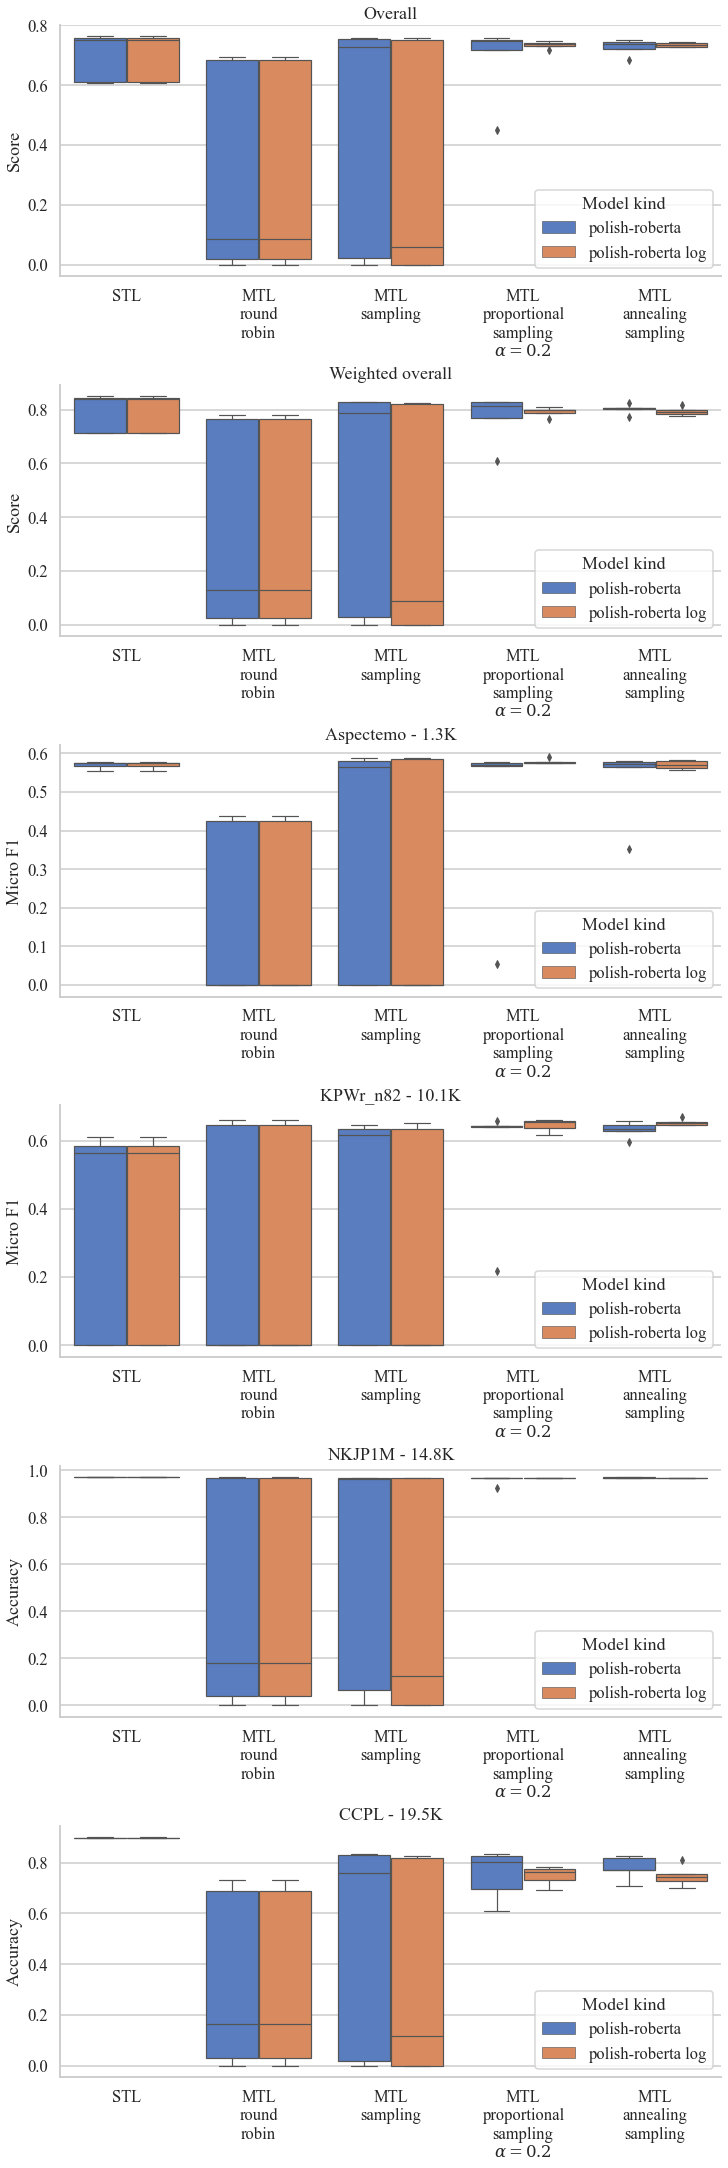

In [14]:
order = ['STL', 'MTL_round_robin', 'MTL_sampling', 
         'MTL_proportional_sampling_$\\alpha=0.2$', 'MTL_annealing_sampling']

hue_order = ['polish-roberta',  'polish-roberta log']

visualize_boxplot(
    df, tasks=tasks,
    cols=1, row_height=5, fig_width=10, all_tasks=True,
    savefig=False, filename='mtl_seq_lab_results_plot',
    showfliers=True, linewidth=1.2, order=order, 
    hue='model_kind', 
    hue_order=hue_order,
    add_legend=True, ncol=1, loc=None, bbox_to_anchor=None, only_fig_legend=False,
    runtimes=False, steps=False, 
)